# DETECTION EMOTION 

# Import library

In [ ]:
#load the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
import keras
import cv2
from zipfile import ZipFile

#load libraries for data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#load libraries for building CNN
from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model

#load libraries for ResNet transfer learning
from tensorflow.keras.applications import ResNet50V2

#load libraries for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#load libraries for visualizing
from tensorflow.keras.utils import plot_model


# Install kaggle

In [ ]:
!pip install kaggle

# Set API kaggle

In [ ]:
# Gantilah dengan API key Anda
api_key = '723ce352e3ec3484075675a5b1dce90e'

In [ ]:
# Nama dataset
dataset_name = 'msambare/fer2013'

# Direktori tempat dataset akan diunduh dan diekstrak
download_dir = '/content/'
extracted_dir = '/content/fer2013/'

In [ ]:
from google.colab import files

# Upload the kaggle.json file that you downloaded from Kaggle
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
# Pindahkan file kaggle.json ke direktori yang sesuai
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Mengatur konfigurasi Kaggle API
os.environ['KAGGLE_USERNAME'] = "permataa"
os.environ['KAGGLE_KEY'] = api_key

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Mengunduh dataset menggunakan Kaggle API
api = KaggleApi()
api.authenticate()  # Tanpa argumen api_key
api.dataset_download_files(dataset_name, path=download_dir, unzip=True)

# Count directory Dataset

In [ ]:
# Definisi direktori train dan test setelah ekstraksi
extracted_dir = '/content/'
train_dir = os.path.join(extracted_dir, 'train')
test_dir = os.path.join(extracted_dir, 'test')

# Fungsi untuk menghitung jumlah kelas emosi
def Classes_Count(path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

# Menghitung jumlah kelas untuk set pelatihan dan pengujian
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

# Menampilkan hasil
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


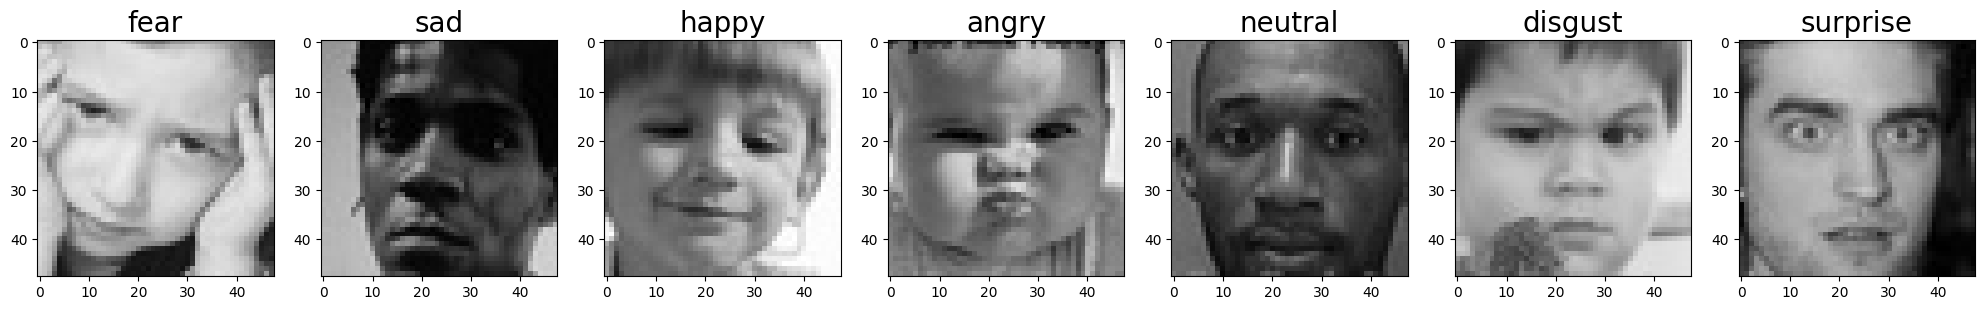

In [ ]:
plt.style.use('default')
plt.figure(figsize=(25, 8))
image_count = 1

# Sesuaikan dengan direktori yang sesuai setelah ekstraksi dataset FER2013
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)

# Path Directory

In [ ]:
img_shape = 48
train_data_path = '/content/train/'
test_data_path = '/content/test/'

# Pre-Processing

In [ ]:
batch_size = 64
#Memproses dan menghasilkan batch gambar selama pelatihan dan pengujian model
#using data generators to generate batches of images
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

#oversampling membantu dalam mengatasi ketidakseimbangan kelas dan dapat meningkatkan performa model
# Konfigurasi generator untuk oversampling
train_oversample = ImageDataGenerator(
    rescale = 1 / 255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

# # Membuat generator untuk data training dengan oversampling
train_data_oversample = train_oversample.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model CNN

In [ ]:
def CNN_Model():

    model = Sequential()

    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))


    #Output
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(7,activation='softmax'))


    return model

In [ ]:
CNN_Model = CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_14 (Ba  (None, 46, 46, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_15 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
history = CNN_Model.fit( train_data ,
                        validation_data= test_data ,
                        epochs=100, batch_size= batch_size,
                        callbacks=callbacks,
                        steps_per_epoch= steps_per_epoch,
                        validation_steps=validation_steps)

Epoch 1/100
448/448 [==============================] - 60s 114ms/step - loss: 2.0385 - accuracy: 0.2050 - val_loss: 1.8245 - val_accuracy: 0.2633 - lr: 0.0010
Epoch 2/100
448/448 [==============================] - 45s 101ms/step - loss: 1.7543 - accuracy: 0.2915 - val_loss: 1.6037 - val_accuracy: 0.3683 - lr: 0.0010
Epoch 3/100
448/448 [==============================] - 44s 97ms/step - loss: 1.6103 - accuracy: 0.3677 - val_loss: 1.4642 - val_accuracy: 0.4266 - lr: 0.0010
Epoch 4/100
448/448 [==============================] - 45s 101ms/step - loss: 1.4829 - accuracy: 0.4211 - val_loss: 1.4051 - val_accuracy: 0.4622 - lr: 0.0010
Epoch 5/100
448/448 [==============================] - 44s 99ms/step - loss: 1.3936 - accuracy: 0.4647 - val_loss: 1.3161 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 6/100
448/448 [==============================] - 47s 104ms/step - loss: 1.3434 - accuracy: 0.4843 - val_loss: 1.2297 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 7/100
448/448 [===========================

In [ ]:
history_with_oversample = CNN_Model.fit(
    train_data_oversample,
    validation_data=test_data,
    epochs=100,
    batch_size=batch_size,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk mengatur tema warna
def set_dark_theme():
    plt.style.use('dark_background')

# Fungsi untuk mereset tema warna ke tema default
def reset_default_theme():
    plt.style.use('default')

# Fungsi untuk plot kurva dengan latar belakang gelap
def plot_curves_dark_theme(history):
    # Set tema warna ke latar belakang gelap
    set_dark_theme()

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Kembalikan tema warna ke default setelah plotting selesai
    reset_default_theme()



In [ ]:
# Plot kurva dengan latar belakang gelap
plot_curves_dark_theme(history)


In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)



In [ ]:
#get the relationship between classes name and numbers
test_data.class_indices

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot confusion matrix with red color
def plot_confusion_matrix(test_labels, predictions):
    cm = confusion_matrix(test_labels, predictions)

    fig, ax = plt.subplots(figsize=(15, 10))

    # Menggunakan palet warna 'Reds'
    sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
    ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
    ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# Memanggil fungsi plot_confusion_matrix dengan labels dan predictions Anda
plot_confusion_matrix(test_data.labels, CNN_Predictions)


# Model ResNet50V2

In [ ]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

In [ ]:
#load data again
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Fine tuning

In [ ]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Freezing all layers except last 50
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_13 (Ba  (None, 64)                256       
 tchNormalization)                                    

In [ ]:
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=100, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/100
448/448 [==============================] - 432s 911ms/step - loss: 1.5985 - accuracy: 0.4530 - val_loss: 1.8323 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 2/100
448/448 [==============================] - 400s 892ms/step - loss: 1.2146 - accuracy: 0.5586 - val_loss: 1.1075 - val_accuracy: 0.5873 - lr: 0.0010
Epoch 3/100
448/448 [==============================] - 394s 879ms/step - loss: 1.1477 - accuracy: 0.5846 - val_loss: 1.0580 - val_accuracy: 0.6066 - lr: 0.0010
Epoch 4/100
448/448 [==============================] - 387s 865ms/step - loss: 1.0662 - accuracy: 0.6114 - val_loss: 1.0234 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 5/100
448/448 [==============================] - 383s 856ms/step - loss: 1.0233 - accuracy: 0.6283 - val_loss: 1.0157 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 6/100
448/448 [==============================] - 387s 863ms/step - loss: 0.9955 - accuracy: 0.6399 - val_loss: 1.0139 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 7/100
448/448 [===================

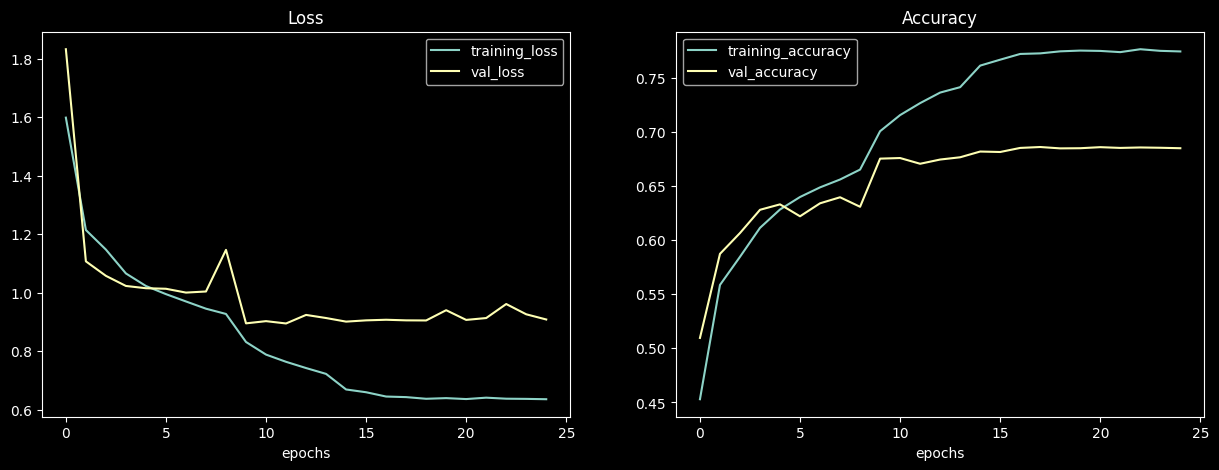

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk mengatur tema warna ke latar belakang gelap
def set_dark_theme():
    plt.style.use('dark_background')

# Fungsi untuk mereset tema warna ke tema default
def reset_default_theme():
    plt.style.use('default')

# Fungsi untuk plot kurva dengan latar belakang gelap
def plot_curves_dark_theme(history):
    # Set tema warna ke latar belakang gelap
    set_dark_theme()

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Kembalikan tema warna ke default setelah plotting selesai
    reset_default_theme()


plot_curves_dark_theme(ResNet50V2_history)
plt.show()


# Evaluating ResNet50V2


In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 21s 187ms/step - loss: 0.9052 - accuracy: 0.6864
    Test Loss: 0.90516
Test Accuracy: 68.64%


# ResNet Confusion Matrix

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 20s 177ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

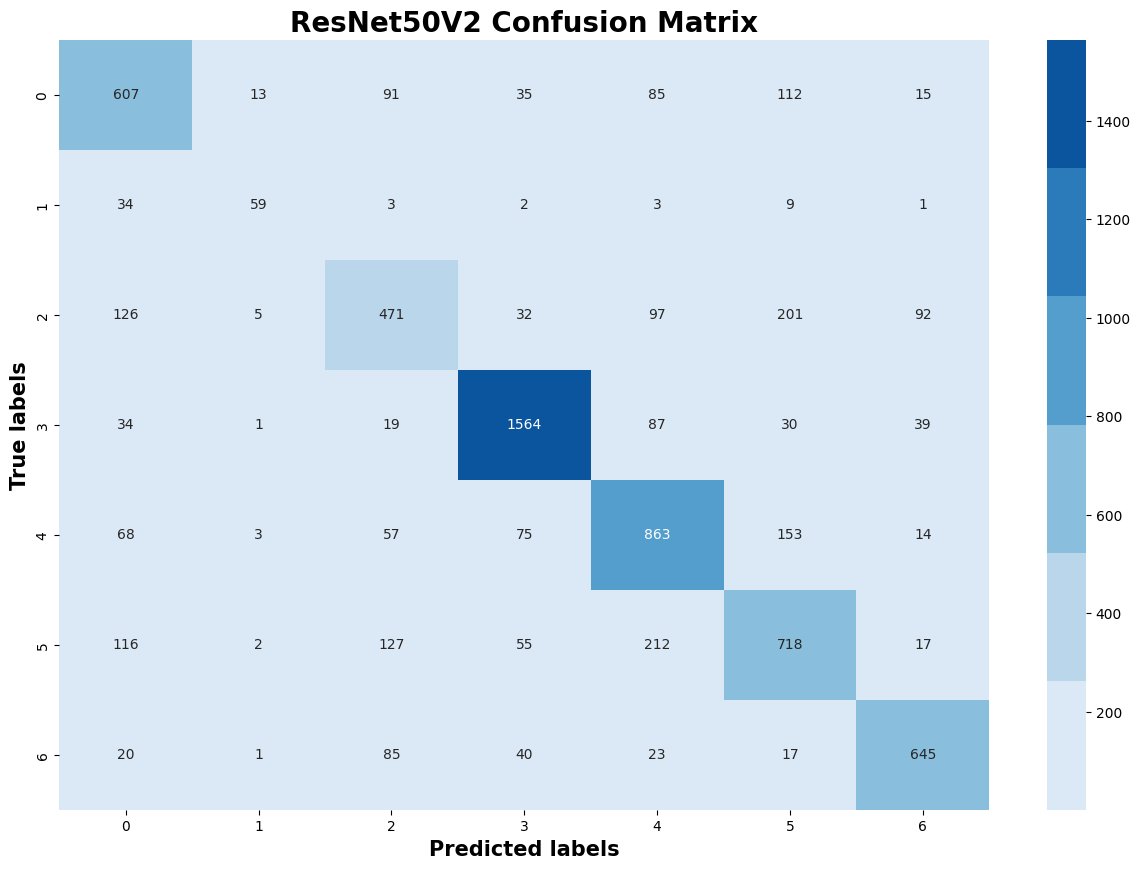

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Pilih palet warna biru
blue_palette = sns.color_palette("Blues")

fig, ax = plt.subplots(figsize=(15, 10))

cm = confusion_matrix(test_data.labels, ResNet50V2_Predictions)

# Gunakan palet warna biru pada heatmap
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=blue_palette)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')


# 5Shuffling Test Data


In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']



# ResNet50V2 Predictions

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


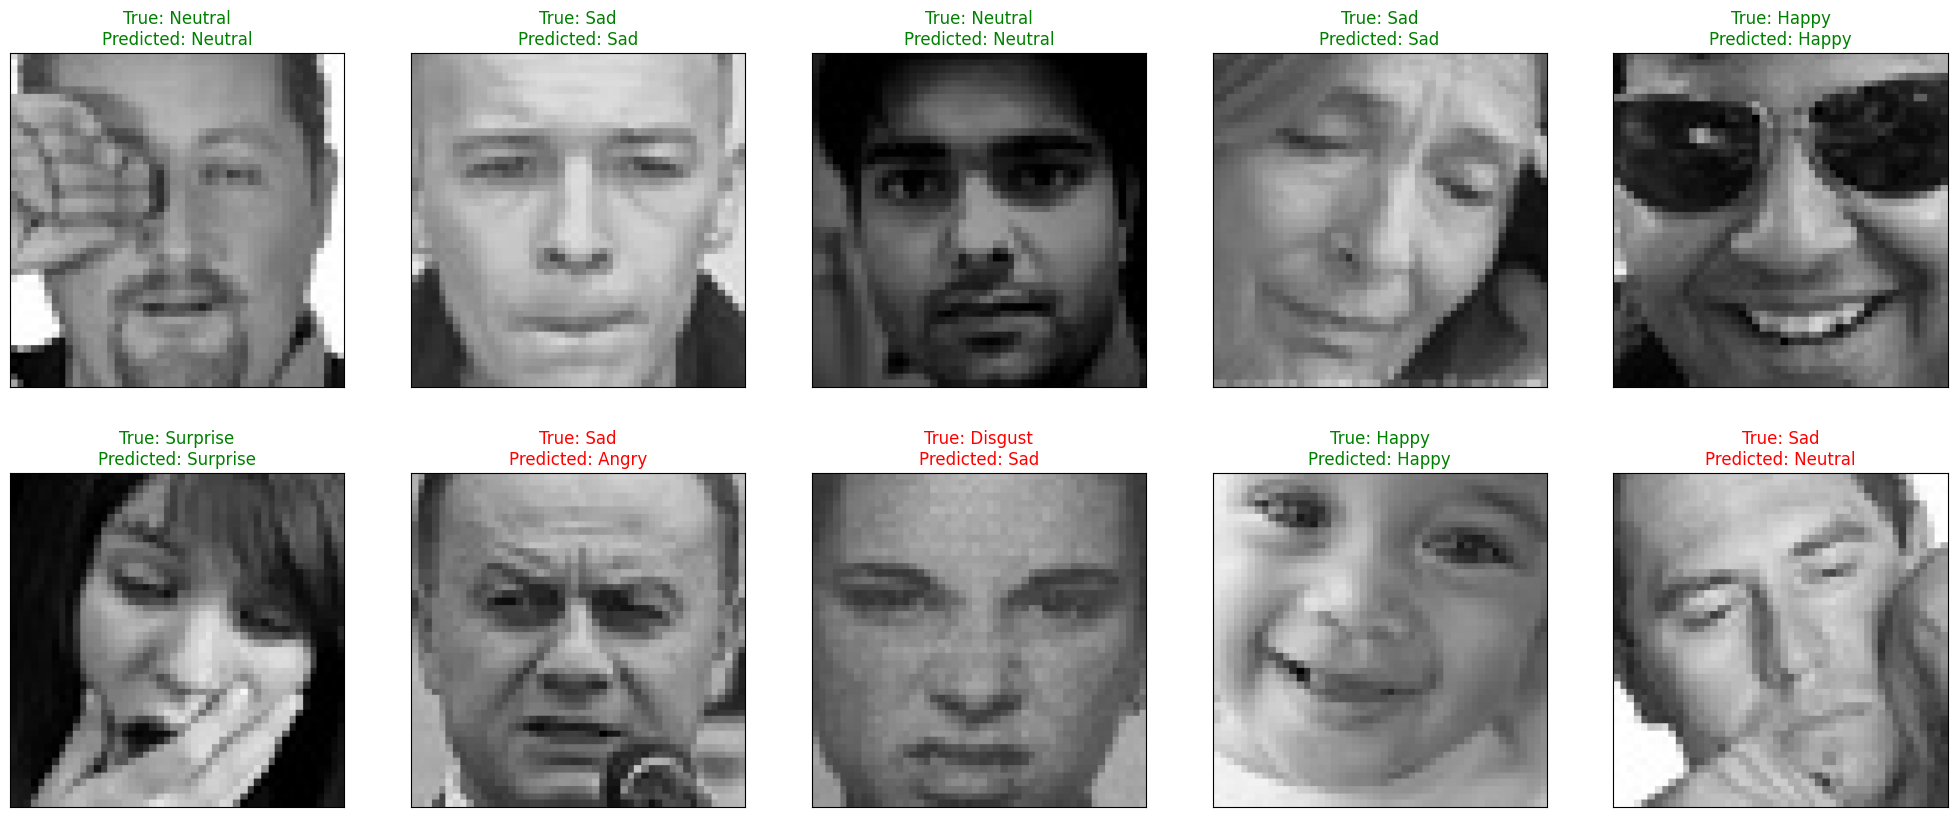

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:

CNN_Model.save("CNN_Model.h5")

#Download model
files.download("CNN_Model.h5")
ResNet50V2_Model.save("ResNet50V2_Model.h5")
files.download("ResNet50V2_Model.h5")
